In [2522]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_columns=50
from matplotlib import style
style.use('ggplot')
from scipy import stats

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

In [2523]:
train = pd.read_csv("C:/Users/kulka/Desktop/AV_Hackathon_Codes/Cross_Sell_Prediction/Data/train.csv")
test  = pd.read_csv("C:/Users/kulka/Desktop/AV_Hackathon_Codes/Cross_Sell_Prediction/Data/test.csv")

In [2524]:
Submission = test[['id']]

In [2525]:
for df in [train,test]:
    df.drop('id',axis=1,inplace=True)

In [2526]:
train.shape, test.shape

((381109, 11), (127037, 10))

In [2527]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 91.0 MB


In [2528]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                127037 non-null  object 
 1   Age                   127037 non-null  int64  
 2   Driving_License       127037 non-null  int64  
 3   Region_Code           127037 non-null  float64
 4   Previously_Insured    127037 non-null  int64  
 5   Vehicle_Age           127037 non-null  object 
 6   Vehicle_Damage        127037 non-null  object 
 7   Annual_Premium        127037 non-null  float64
 8   Policy_Sales_Channel  127037 non-null  float64
 9   Vintage               127037 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 29.4 MB


In [2529]:
train.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [2530]:
test.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

#### EDA (Dependent Variable)

In [2531]:
len(train[train['Response']==0]),len(train[train['Response']==1])

(334399, 46710)

In [2532]:
len(train[train['Response']==0])/len(train[train['Response']==1])

7.15904517233997

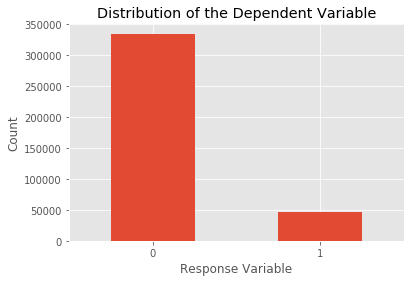

In [2533]:
train['Response'].value_counts(dropna=False).plot(kind='bar');
plt.xticks(rotation=360);
plt.title("Distribution of the Dependent Variable");
plt.xlabel("Response Variable");
plt.ylabel("Count");

1. The dependent variable is imbalanced, the extent of imbalance in the data is not that significant though.
2. Very few of the customers have responded to the campaign with a Yes.

#### EDA (Independent Variables)

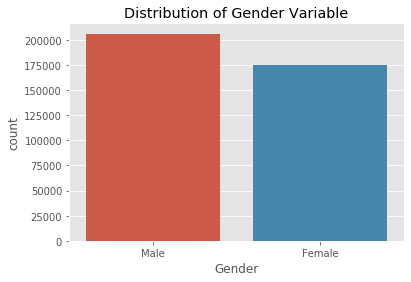

In [2534]:
sns.countplot(train['Gender']);
plt.title("Distribution of Gender Variable");
# We can see that the two genders are almost in equal proportion. 

In [2535]:
train['Age'].describe()
# The minimum and Maximum age are 20 and 85 respectively.
# The median age is 36 and the average age is 38. 

count    381109.000000
mean         38.822584
std          15.511611
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64

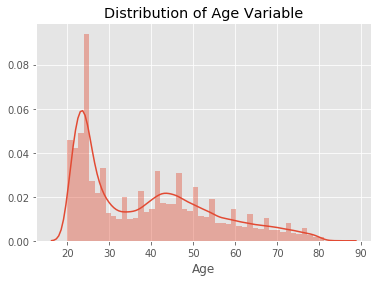

In [2536]:
sns.distplot(train['Age'],kde=True);
plt.title("Distribution of Age Variable");
# We can see a majority of the people are between ages 20-30 and as the age increases, the number of respondents per age group decreases.

In [2537]:
train['Driving_License'].value_counts(dropna=False)
# We can see this variable is highly imbalanced, more than 99% of the respondents have driving license. 

1    380297
0       812
Name: Driving_License, dtype: int64

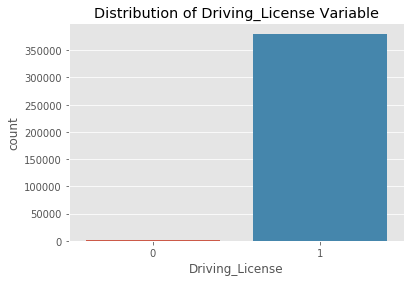

In [2538]:
sns.countplot(train['Driving_License']);
plt.title("Distribution of Driving_License Variable");

In [2539]:
train['Region_Code'].nunique(),test['Region_Code'].nunique()

(53, 53)

In [2540]:
train['Region_Code'].value_counts(dropna=False).sort_values(ascending=False)

28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
23.0      1960
31.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: Region_Code, dtype: int64

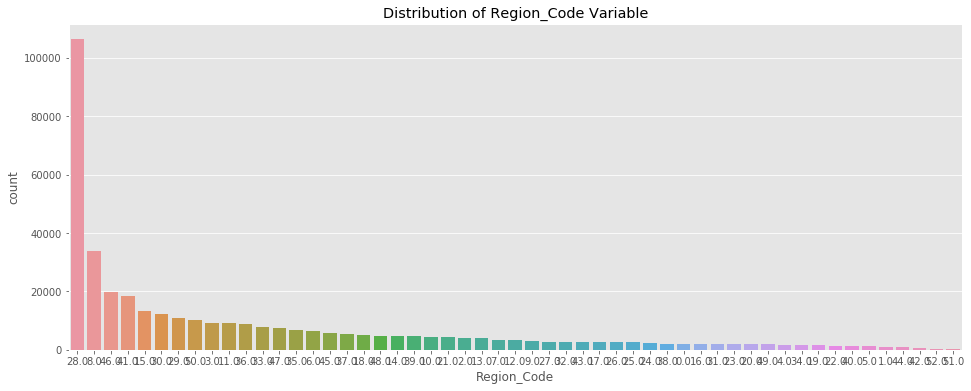

In [2541]:
plt.figure(figsize=(16,6));
sns.countplot(x="Region_Code",data=train,order = train['Region_Code'].value_counts().index);
plt.title("Distribution of Region_Code Variable");

In [2542]:
# There are totally 53 unique Regio codes.
# Almost 1/3rd of the respondents are from the Region Code 28, followed by Region code 8.
# Some of the regions have negligible number of respondents like region 52 etc. 

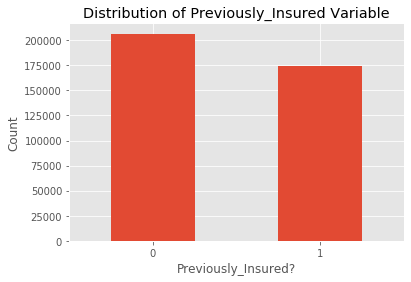

In [2543]:
train['Previously_Insured'].value_counts(dropna=False).plot(kind='bar');
plt.title("Distribution of Previously_Insured Variable");
plt.xlabel("Previously_Insured?");
plt.ylabel("Count");
plt.xticks(rotation=360);
# Majority of the customers were not insured previously.

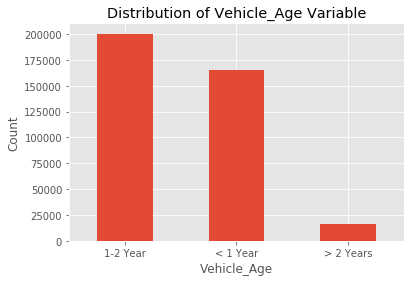

In [2544]:
train['Vehicle_Age'].value_counts(dropna=False).plot(kind='bar');
plt.title("Distribution of Vehicle_Age Variable");
plt.xlabel("Vehicle_Age");
plt.ylabel("Count");
plt.xticks(rotation=360);
# Most of the vehicles are between the age 1-2 years followed by <1 year old. 

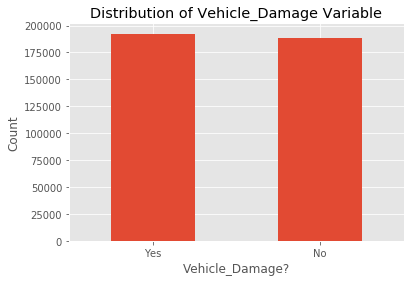

In [2545]:
train['Vehicle_Damage'].value_counts(dropna=False).plot(kind='bar');
plt.title("Distribution of Vehicle_Damage Variable");
plt.xlabel("Vehicle_Damage?");
plt.ylabel("Count");
plt.xticks(rotation=360);
# The distribution in this variable is almost the same. 
# one has to also check the distribution of Vehicle_Damage variable with age of the vehicle.

In [2546]:
train['Annual_Premium'].describe()

count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

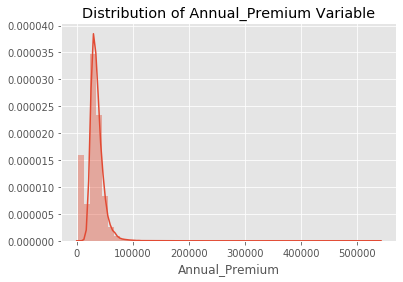

In [2547]:
sns.distplot(train['Annual_Premium'],kde=True);
plt.title("Distribution of Annual_Premium Variable");
# Majority of the premiums are between 0 to 50000 with a few values which are very high.

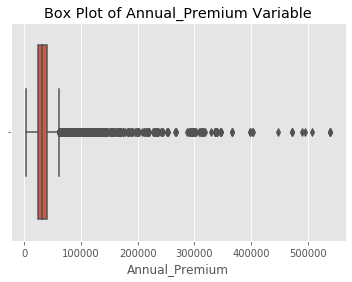

In [2548]:
sns.boxplot(train['Annual_Premium']);
plt.title("Box Plot of Annual_Premium Variable");
# We can see a lot of values that are above the accepted values.

In [2549]:
IQR = train['Annual_Premium'].quantile(0.75)-train['Annual_Premium'].quantile(0.25)
Upper_Range = train['Annual_Premium'].quantile(0.75)+1.5*IQR
Lower_Range = train['Annual_Premium'].quantile(0.25)-1.5*IQR
print (Upper_Range,Lower_Range)

61892.5 1912.5


In [2550]:
train[(train['Annual_Premium']>Upper_Range) | (train['Annual_Premium']<Lower_Range)]

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
25,Female,21,1,28.0,1,< 1 Year,No,61964.0,152.0,72,0
37,Female,25,1,28.0,1,< 1 Year,No,76251.0,152.0,107,0
67,Male,60,1,28.0,0,1-2 Year,Yes,66338.0,124.0,73,0
139,Male,21,1,29.0,1,< 1 Year,No,62164.0,152.0,116,0
149,Female,22,1,11.0,1,< 1 Year,No,76651.0,152.0,258,0
...,...,...,...,...,...,...,...,...,...,...,...
380959,Male,25,1,8.0,1,< 1 Year,No,61909.0,152.0,161,0
380998,Female,33,1,8.0,0,1-2 Year,Yes,101664.0,124.0,21,0
381035,Female,22,1,11.0,1,< 1 Year,No,62889.0,152.0,295,0
381047,Female,52,1,8.0,1,1-2 Year,No,71915.0,7.0,233,0


In [2551]:
# We can consider premiums above 61892 and premiums below 1912 as potential outliers, but this is again subject to investigation
# There are 10320 records in the train data which are above the upper range and below the lower range.

In [2552]:
# There are 155 unique Policy Sales Channels, or 155 unique ways in which a customer is reached.
# As we can see below, channels like 152,26,124,160 and 156 account to a majority of the outreach methods. 

In [2553]:
train['Policy_Sales_Channel'].value_counts(dropna=False).sort_values(ascending=False).head(10)

152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
122.0      9930
157.0      6684
154.0      5993
151.0      3885
163.0      2893
Name: Policy_Sales_Channel, dtype: int64

In [2554]:
train['Policy_Sales_Channel'].value_counts(dropna=False).sort_values(ascending=False).tail(10)

112.0    2
74.0     2
75.0     2
84.0     1
144.0    1
149.0    1
143.0    1
123.0    1
41.0     1
43.0     1
Name: Policy_Sales_Channel, dtype: int64

In [2555]:
train['Vintage'].describe()

count    381109.000000
mean        154.347397
std          83.671304
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

In [2556]:
# The minimum number of days a customer is associated with the company is 10 and the maximum is 299.
# The average number of days a customer is associated with the company is 154 and the median value is 154.

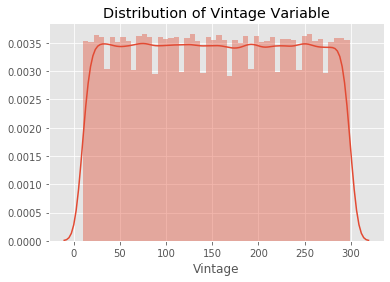

In [2557]:
sns.distplot(train['Vintage'],kde=True);
plt.title("Distribution of Vintage Variable");

#### EDA (Bi-Variate)

In [2558]:
# Dependent Variable by Gender

In [2559]:
train.groupby("Gender")['Response'].value_counts(normalize=True)

Gender  Response
Female  0           0.896098
        1           0.103902
Male    0           0.861589
        1           0.138411
Name: Response, dtype: float64

In [2560]:
# We can see that the percentage of Male customers responding with a Yes is higher than the percentage of Female customers responding with a Yes. 

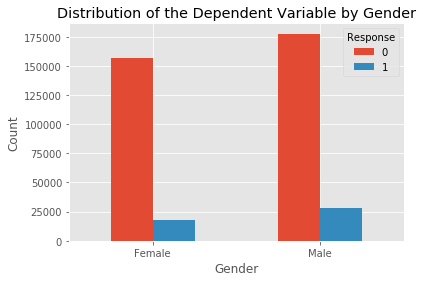

In [2561]:
train.groupby("Gender")['Response'].value_counts().unstack().plot(kind='bar');
plt.title("Distribution of the Dependent Variable by Gender");
plt.xticks(rotation=360);
plt.ylabel("Count");

In [2562]:
# Age by Dependent Variable

In [2563]:
train.groupby("Response")['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,334399.0,38.178227,15.816052,20.0,24.0,34.0,49.0,85.0
1,46710.0,43.435560,12.168924,20.0,35.0,43.0,51.0,83.0


In [2564]:
# We can see that the mean age of customers who responded with a Yes is higher than customers who responded with a No.
# The similar behavior is observed with the median age. 
# The maximum age is same for both the categories.

In [2565]:
# Dependent variable by Driving License

In [2566]:
train.groupby("Driving_License")['Response'].value_counts(normalize=True)

Driving_License  Response
0                0           0.949507
                 1           0.050493
1                0           0.877283
                 1           0.122717
Name: Response, dtype: float64

In [2567]:
# only 12% of the customers who have driving license have responded with a Yes (1).
# Since we have a handful of customers who do not have a driving license, we do not see the bar in the below plot.

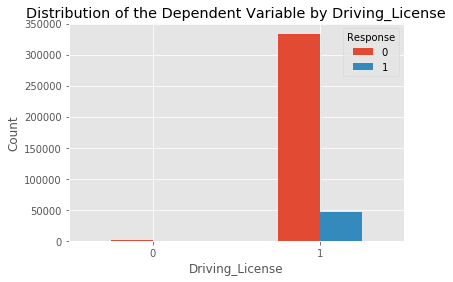

In [2568]:
train.groupby("Driving_License")['Response'].value_counts().unstack().plot(kind='bar');
plt.title("Distribution of the Dependent Variable by Driving_License");
plt.xticks(rotation=360);
plt.ylabel("Count");

In [2569]:
# Dependent variable by Region_Code

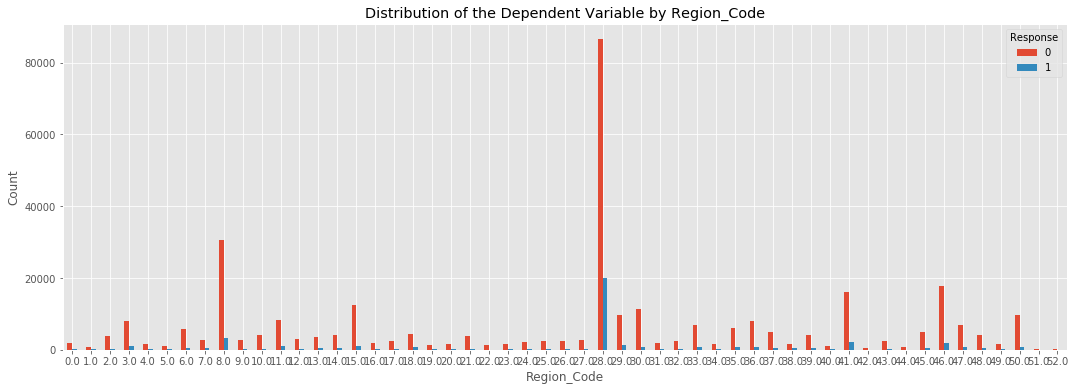

In [2570]:
train.groupby("Region_Code")['Response'].value_counts().unstack().plot(kind='bar',figsize=(18,6));
plt.title("Distribution of the Dependent Variable by Region_Code");
plt.xticks(rotation=360);
plt.ylabel("Count");

In [2571]:
# It is safe to say that those who responded with a Yes are mostly from Region Code 28 followed by Region Codes 8, 41 and 46.

In [2572]:
# Dependent variable by Previously_Insured

In [2573]:
train.groupby("Previously_Insured")['Response'].value_counts(normalize=True)

Previously_Insured  Response
0                   0           0.774546
                    1           0.225454
1                   0           0.999095
                    1           0.000905
Name: Response, dtype: float64

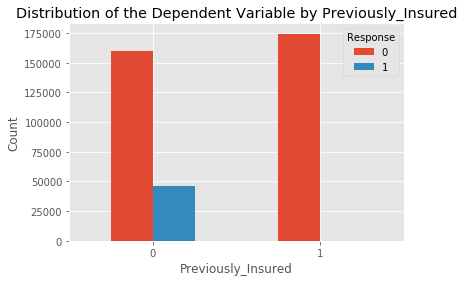

In [2574]:
train.groupby("Previously_Insured")['Response'].value_counts().unstack().plot(kind='bar');
plt.title("Distribution of the Dependent Variable by Previously_Insured");
plt.xticks(rotation=360);
plt.ylabel("Count");

In [2575]:
# We can see an interesting insight here, if the vehicle is previously insured, almost all of the respondents responded with No

In [2576]:
# Dependent variable by Vehicle_Age

In [2577]:
train.groupby("Vehicle_Age")['Response'].value_counts(normalize=True)

Vehicle_Age  Response
1-2 Year     0           0.826245
             1           0.173755
< 1 Year     0           0.956295
             1           0.043705
> 2 Years    0           0.706254
             1           0.293746
Name: Response, dtype: float64

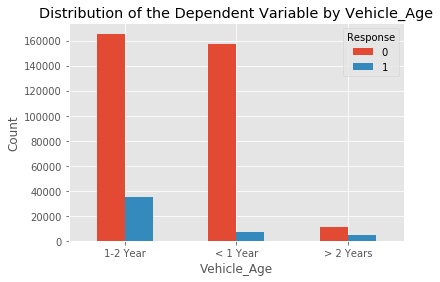

In [2578]:
train.groupby("Vehicle_Age")['Response'].value_counts().unstack().plot(kind='bar');
plt.title("Distribution of the Dependent Variable by Vehicle_Age");
plt.xticks(rotation=360);
plt.ylabel("Count");

In [2579]:
# We can see that if the vehicle is greater than 2 years old , then there is 25% chance of customers responding with a Yes.

In [2580]:
# Dependent variable by Vehicle_Damage

In [2581]:
train.groupby("Vehicle_Damage")['Response'].value_counts(normalize=True)

Vehicle_Damage  Response
No              0           0.994796
                1           0.005204
Yes             0           0.762345
                1           0.237655
Name: Response, dtype: float64

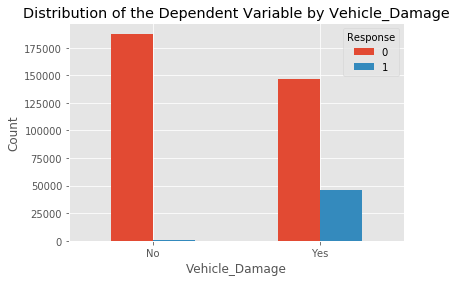

In [2582]:
train.groupby("Vehicle_Damage")['Response'].value_counts().unstack().plot(kind='bar');
plt.title("Distribution of the Dependent Variable by Vehicle_Damage");
plt.xticks(rotation=360);
plt.ylabel("Count");

In [2583]:
# When the vehicle is damaged or was damaged, there is 23% chance of customers responding with Yes to a campaign.
# When the vehicle is not damaged, there is very very less chance.

In [2584]:
# Annual_Premium by Dependent variable

In [2585]:
train.groupby("Response")['Annual_Premium'].describe()

,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,334399.0,30419.160276,16998.293197,2630.0,24351.0,31504.0,39120.0,540165.0
1,46710.0,31604.092742,18646.508040,2630.0,24868.0,33002.0,41297.0,540165.0


In [2586]:
# We can see that if the Response is 1, the Mean Annual Premium amount is higher than if the response is 0.
# Similarly, the Median value is higher and the standard deviation is also higher.

In [2587]:
# Vintage by Dependent Variable

In [2588]:
train.groupby("Response")['Vintage'].describe()

,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,334399.0,154.380243,83.661975,10.0,82.0,154.0,227.0,299.0
1,46710.0,154.112246,83.738574,10.0,82.0,154.0,226.0,299.0


In [2589]:
# There is not much difference we can find here. 

In [2590]:
# Let's find the relation ship between Vehicle Age and Vehicle Damage

In [2591]:
pd.crosstab(index=train['Vehicle_Age'],columns=train['Vehicle_Damage'],margins=True)

Vehicle_Damage,No,Yes,All
Vehicle_Age,,,
1-2 Year,72091,128225,200316
< 1 Year,116590,48196,164786
> 2 Years,15,15992,16007
All,188696,192413,381109


1. We can see that if the vehicle is more than 2 years old, it is highly likely that it is or it was damaged.
2. If the Vehicle is less than a year old, it has high chance that it is not damaged.
3. If it is between 1-2 years old, then too it has high chance of being damaged. 

In [2592]:
# Let's find the relationship between vehicle damage and previously insured variables.

In [2593]:
pd.crosstab(index=train['Previously_Insured'],columns=train['Vehicle_Damage'],margins=True)

Vehicle_Damage,No,Yes,All
Previously_Insured,,,
0,23990,182491,206481
1,164706,9922,174628
All,188696,192413,381109


1. We can see that, if the vehicle is previously insured, then it has high chance that it is not damaged. 
2. If it is not previously insured, then it has high chance that it is damaged.

In [2594]:
# Let's see the Age distribution between two genders.

In [2595]:
train.groupby("Gender")['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,175020.0,36.372746,15.223969,20.0,24.0,30.0,46.0,85.0
Male,206089.0,40.903095,15.449718,20.0,26.0,41.0,52.0,85.0


1. Mean age of Male customers is higher than Female customers.
2. Median age is higher in Male customers too.

In [2596]:
# Let's see the relationship between Previously_Insuerd and Vehicle_Age variable

In [2597]:
pd.crosstab(index=train['Previously_Insured'],columns=train['Vehicle_Age'],margins=True)

Vehicle_Age,1-2 Year,< 1 Year,> 2 Years,All
Previously_Insured,,,,
0,134991,55529,15961,206481
1,65325,109257,46,174628
All,200316,164786,16007,381109


1. We can see that if the Vehicle is previously insured, then it is highly unlikely that it is more than 2 years old.
2. If a vehicle is greater than 2 years old, it is higly likely that it is not previously insured. 

#### Correlation

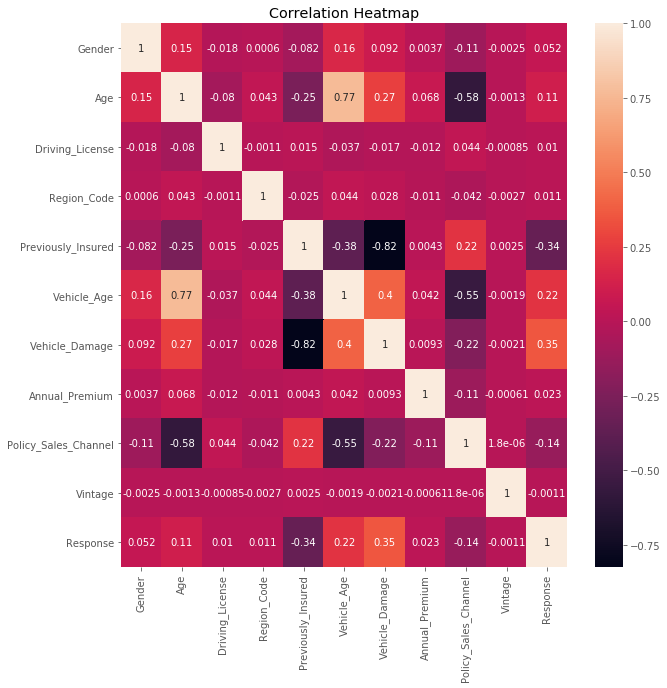

In [2598]:
df_train = train.copy()
df_test  = test.copy()

Vehicle_Age_Map = {"< 1 Year":0,"1-2 Year":1,"> 2 Years":2}
Vehicle_Damage_Map = {"Yes":1,"No":0}
Gender_Map = {"Male":1,"Female":0}

for df in [df_train,df_test]:
    df['Vehicle_Age'] = df['Vehicle_Age'].map(Vehicle_Age_Map)
    df['Vehicle_Damage'] = df['Vehicle_Damage'].map(Vehicle_Damage_Map)
    df['Gender'] = df['Gender'].map(Gender_Map)
    
plt.figure(figsize=(10,10));
sns.heatmap(df_train.corr(),annot=True);
plt.title("Correlation Heatmap");

In [2599]:
# We can see that Only Previously_Insured and Vehicle_Damage has some correlation with the dependent variable.
# We can also see that Vehicle_Damage and Previously_Insured have high correlation between them, so do Vehicle_Age and Age.

#### Feature Engineering

In [2600]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [2601]:
test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [2602]:
Vehicle_Age_Map = {"< 1 Year":0,"1-2 Year":1,"> 2 Years":2}
Vehicle_Damage_Map = {"Yes":1,"No":0}
Gender_Map = {"Male":1,"Female":0}

train['Source'] = "Train"
test['Source'] = "Test"
df = pd.concat([train,test])

df['Vehicle_Age'] = df['Vehicle_Age'].map(Vehicle_Age_Map)
df['Vehicle_Damage'] = df['Vehicle_Damage'].map(Vehicle_Damage_Map)
df['Gender'] = df['Gender'].map(Gender_Map)

In [2603]:
df['Mean_Premium_Per_Region_Code'] = df.groupby("Region_Code")['Annual_Premium'].transform("mean")
df['Mean_Premium_Per_Policy_Sales_Channel'] = df.groupby("Policy_Sales_Channel")['Annual_Premium'].transform("mean")
df['Mean_Premium_Per_Vehicle_Age'] = df.groupby("Vehicle_Age")['Annual_Premium'].transform("mean")
df['Mean_Premium_Per_Vehicle_Damage'] = df.groupby("Vehicle_Damage")['Annual_Premium'].transform("mean")

In [2604]:
df['Median_Premium_Per_Region_Code'] = df.groupby("Region_Code")['Annual_Premium'].transform("median")
df['Median_Premium_Per_Policy_Sales_Channel'] = df.groupby("Policy_Sales_Channel")['Annual_Premium'].transform("median")

In [2605]:
df['Std_Premium_Per_Region_Code'] = df.groupby("Region_Code")['Annual_Premium'].transform("std")
df['Std_Premium_Per_Policy_Sales_Channel'] = df.groupby("Policy_Sales_Channel")['Annual_Premium'].transform("std")

In [2606]:
df['Premium_Per_Month'] = df['Annual_Premium']/12

In [2607]:
def Age_Bracket(x):
    if (x>20 and x<30):
        return 1
    elif (x>=30 and x<40):
        return 2
    elif (x>=40 and x<50):
        return 3
    elif (x>=50 and x<60):
        return 4
    elif (x>=60 and x<70):
        return 5
    elif (x>=70 and x<80):
        return 6
    else:
        return 7
    
df['Age_Bin'] = df['Age'].apply(Age_Bracket)
df['Age_Bin'] = df['Age_Bin'].astype("uint8")

In [2608]:
def Premium_Bracket(x):
    if (x<20000):
        return 1
    elif (x>=20000 and x<40000):
        return 2
    elif (x>=40000 and x<60000):
        return 3
    else:
        return 4
    
df['Premium_Bin'] = df['Annual_Premium'].apply(Premium_Bracket)
df['Premium_Bin'] = df['Premium_Bin'].astype("uint8")

In [2609]:
df['Number_Policy_Sales_Channels_Per_Region'] = df.groupby("Region_Code")['Policy_Sales_Channel'].transform("nunique")
df['Policy_Sales_Channel_In_Regions'] = df.groupby("Policy_Sales_Channel")['Region_Code'].transform("nunique")

In [2610]:
train=df.loc[df.Source.isin(['Train'])]
test=df.loc[df.Source.isin(['Test'])]
train.drop(columns={'Source'},axis=1,inplace=True)
test.drop(['Source','Response'],axis=1,inplace=True)

C:\Users\kulka\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [2611]:
region_counts_train = train['Region_Code'].value_counts().to_dict()
train['Region_Code_Count'] = train['Region_Code'].map(region_counts_train)
region_counts_test = test['Region_Code'].value_counts().to_dict()
test['Region_Code_Count'] = test['Region_Code'].map(region_counts_test)

C:\Users\kulka\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kulka\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [2612]:
policy_sales_channel_count_train = train['Policy_Sales_Channel'].value_counts().to_dict()
train['Policy_Sales_Channel_Count'] = train['Policy_Sales_Channel'].map(policy_sales_channel_count_train)
policy_sales_channel_count_test = test['Policy_Sales_Channel'].value_counts().to_dict()
test['Policy_Sales_Channel_Count'] = test['Policy_Sales_Channel'].map(policy_sales_channel_count_test)

C:\Users\kulka\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kulka\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [2613]:
cat_cols = ['Gender','Driving_License','Region_Code','Previously_Insured','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel']
num_cols = [col for col in train.columns if col not in cat_cols and col!= "Response"]

In [2614]:
y = train['Response']
X = train[[col for col in train.columns if col!="Response"]]

In [2615]:
# The reason for using binary_logloss as the evaluation metric in the model below is in the following link
# https://stats.stackexchange.com/questions/260164/auc-and-class-imbalance-in-training-test-dataset
# Although it optimizes logloss metric, it resulted in slight increase in the LB scores. 

In [2616]:
lgb_predictions = np.zeros(test.shape[0])
folds = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
roc_score = []
for train_index,test_index in folds.split(X,y,):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    clf = lgb.LGBMClassifier(objective='binary',
                             n_jobs=-1,
                             boosting_type="gbdt",
                             learning_rate=0.05,
                             n_estimators=500,
                             subsample=0.9,
                             colsample_bytree=0.7,
                             metric='binary_logloss',
                             max_depth=12,
                             reg_lambda=0.5,
                             reg_alpha=0.5,
                             num_leaves=75,
                             min_child_samples=20,
                             is_unbalanced=True)
    
    clf.fit(x_train,
            y_train,
            eval_set=[(x_train,y_train),(x_val,y_val)],
            early_stopping_rounds=50,
            verbose=100,
            categorical_feature = cat_cols)
    
    
    preds = clf.predict_proba(x_val)[:, 1]
    score = roc_auc_score(y_val,preds)
    print ("ROC AUC Score:",score)
    print ("------------------------------------------------")
    roc_score.append(score)
    
    
    # Predicting on the test set
    lgb_predictions += clf.predict_proba(test)[:, 1] / folds.n_splits
    
print ("------------------------------------------")
print ("Mean ROC AUC Score of 5 Folds:",np.mean(np.array(roc_score)))

C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Driving_License', 'Gender', 'Policy_Sales_Channel', 'Previously_Insured', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.257318	valid_1's binary_logloss: 0.26453
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.254994	valid_1's binary_logloss: 0.264307
ROC AUC Score: 0.8575511774332413
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Driving_License', 'Gender', 'Policy_Sales_Channel', 'Previously_Insured', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.25703	valid_1's binary_logloss: 0.264731
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.255366	valid_1's binary_logloss: 0.264487
ROC AUC Score: 0.857293293605613
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Driving_License', 'Gender', 'Policy_Sales_Channel', 'Previously_Insured', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.257026	valid_1's binary_logloss: 0.264892
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.255261	valid_1's binary_logloss: 0.264734
ROC AUC Score: 0.8575577508107645
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Driving_License', 'Gender', 'Policy_Sales_Channel', 'Previously_Insured', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.257346	valid_1's binary_logloss: 0.264215
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.255789	valid_1's binary_logloss: 0.264118
ROC AUC Score: 0.8592300383794337
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Driving_License', 'Gender', 'Policy_Sales_Channel', 'Previously_Insured', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.257362	valid_1's binary_logloss: 0.263686
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.2556	valid_1's binary_logloss: 0.263561
ROC AUC Score: 0.8601486827076186
------------------------------------------------
------------------------------------------
Mean ROC AUC Score of 5 Folds: 0.8583561885873342


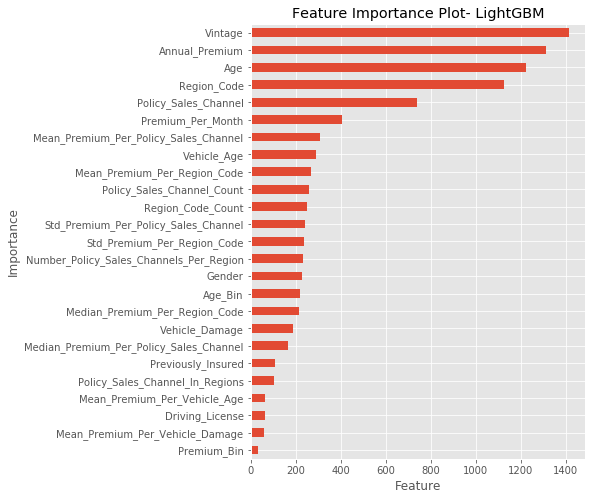

In [2617]:
# plotting Feature Importance
plt.figure(figsize=(6,8));
ser = pd.Series(clf.feature_importances_,X.columns).sort_values();
ser.plot(kind='barh');
plt.title("Feature Importance Plot- LightGBM");
plt.xlabel("Feature");
plt.ylabel("Importance");

Text(0.5, 0, 'False positive rate')

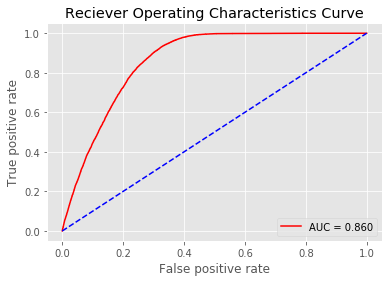

In [2618]:
probability = clf.predict_proba(x_val)[:,1]
frp,trp, threshold = roc_curve(y_val,probability)
roc_auc_ = auc(frp,trp)
plt.title('Reciever Operating Characteristics Curve')
plt.plot(frp,trp,'r',label = 'AUC = %0.3f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

In [2619]:
Submission['Response'] = lgb_predictions
Submission.to_csv("Solution.csv",index=None)

In [2620]:
Submission

,id,Response
0,381110,0.000715
1,381111,0.342141
2,381112,0.292311
3,381113,0.005130
4,381114,0.000747
...,...,...
127032,508142,0.000922
127033,508143,0.361167
127034,508144,0.000523
127035,508145,0.000566
